<a href="https://colab.research.google.com/github/saikiran-18/Air_quality_index_predictor/blob/main/Air_Quality_Index_Predictor_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASSIFICATION MODEL FOR AQI PREDICTION (AQI)

---



Shape: (10000, 12)

Columns: ['City', 'Country', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']

Head:
              City   Country        Date   PM2.5    PM10    NO2    SO2    CO  \
0         Bangkok  Thailand  2023-03-19   86.57   25.19  99.88  30.63  4.46   
1        Istanbul    Turkey  2023-02-16   50.63   97.39  48.14   8.71  3.40   
2  Rio de Janeiro    Brazil  2023-11-13  130.21   57.22  98.51   9.92  0.12   
3          Mumbai     India  2023-03-16  119.70  130.52  10.96  33.03  7.74   
4           Paris    France  2023-04-04   55.20   36.62  76.85  21.85  2.00   

       O3  Temperature  Humidity  Wind Speed  
0   36.29        17.67     59.35       13.76  
1  144.16         3.46     67.51        6.36  
2  179.31        25.29     29.30       12.87  
3   38.65        23.15     99.97        7.71  
4   67.09        16.02     90.28       14.16  

Missing values:
 City           0
Country        0
Date           0
PM2.5          0
PM10    

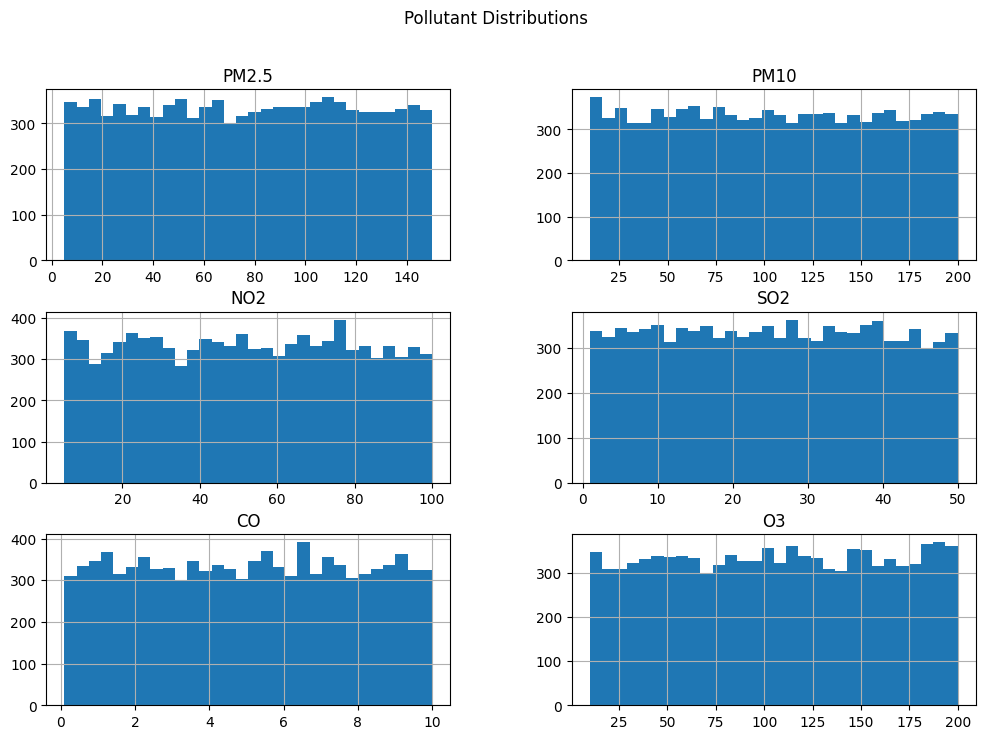

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

DATA_PATH = "global_air_quality_data.csv"
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"Error: The file '{DATA_PATH}' was not found. Please ensure it's in the same directory.")
    exit()

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns
#VISUALIZATION
# Histogram of pollutants
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
df[pollutants].hist(bins=30, figsize=(12,8))
plt.suptitle("Pollutant Distributions")
plt.show()

In [19]:
 #Preprocessing

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# --- Helper function for AQI calculation based on EPA breakpoints ---
pm25_breakpoints = [
    (0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300),
    (250.5, 350.4, 301, 400), (350.5, 500.4, 401, 500)
]
pm10_breakpoints = [
    (0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
    (255, 354, 151, 200), (355, 424, 201, 300),
    (425, 504, 301, 400), (505, 604, 401, 500)
]

def interp_subindex(C, bp_table):
    for (BP_low, BP_high, I_low, I_high) in bp_table:
        if C >= BP_low and C <= BP_high:
            return ((I_high - I_low) / (BP_high - BP_low)) * (C - BP_low) + I_low
    if C < bp_table[0][0]:
        return bp_table[0][2]
    return bp_table[-1][3]

def compute_aqi_row(r):
    aqi_pm25 = interp_subindex(r['PM2.5'], pm25_breakpoints)
    aqi_pm10 = interp_subindex(r['PM10'], pm10_breakpoints)
    aqi_no2 = (r['NO2'] / 400.0) * 500.0
    aqi_so2 = (r['SO2'] / 500.0) * 500.0
    aqi_co = (r['CO'] / 50.0) * 500.0
    aqi_o3 = (r['O3'] / 300.0) * 500.0
    sub_indices = [max(0.0, v) for v in [aqi_pm25, aqi_pm10, aqi_no2, aqi_so2, aqi_co, aqi_o3]]
    return float(np.max(sub_indices))

df['AQI'] = df.apply(compute_aqi_row, axis=1)

FEATURES = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']
X = df[FEATURES].astype(float)
y = df['AQI'].astype(float)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [20]:
# Define the aqi_to_category function
def aqi_to_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy-SG" # Unhealthy for Sensitive Groups
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

In [21]:
print("\n- BUILDING A CLASSIFICATION MODEL")

AQI_CATEGORIES = ["Good", "Moderate", "Unhealthy-SG", "Unhealthy", "Very Unhealthy", "Hazardous"]
num_classes = len(AQI_CATEGORIES)

# --- Preprocessing for Classification (One-Hot Encoding) ---
y_class = df['AQI'].apply(aqi_to_category)

# Split y_class before encoding to match the X split
y_train_class_cat = y_class.iloc[y_train.index]
y_test_class_cat = y_class.iloc[y_test.index]

encoder = LabelEncoder()
# Fit the encoder on ALL possible categories to ensure all are known
encoder.fit(AQI_CATEGORIES)

# Transform both training and testing data using the fitted encoder
encoded_y_train = encoder.transform(y_train_class_cat)
encoded_y_test = encoder.transform(y_test_class_cat)


y_train_one_hot = to_categorical(encoded_y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(encoded_y_test, num_classes=num_classes)


X_train_class = X_train_scaled # X_train_scaled is already the training set
X_test_class = X_test_scaled # X_test_scaled is already the testing set

print("\nPreprocessing for classification done. y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)


- BUILDING A CLASSIFICATION MODEL

Preprocessing for classification done. y_train_one_hot shape: (8000, 6)
y_test_one_hot shape: (2000, 6)


##--- Classification Model Architecture ---

---



In [22]:
def build_classification_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_dim = X_train_scaled.shape[1]
model_class = build_classification_model(input_dim, num_classes)
print("\nClassification Model Summary:")
model_class.summary()


Classification Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,302 (12.90 KB)

 Trainable params: 3,110 (12.15 KB)

 Non-trainable params: 192 (768.00 B)

##--- Training the Classification Model ---

In [23]:
model_class.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping_class = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_class = model_class.fit(
    X_train_scaled, y_train_one_hot,
    validation_split=0.15,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_class],
    verbose=1
)
print("\nTraining of classification model finished.")

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3932 - loss: 1.6153 - val_accuracy: 0.6975 - val_loss: 0.9296
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6923 - loss: 0.7643 - val_accuracy: 0.7692 - val_loss: 0.5524
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7423 - loss: 0.6201 - val_accuracy: 0.8233 - val_loss: 0.4422
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7794 - loss: 0.5450 - val_accuracy: 0.8992 - val_loss: 0.3800
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7958 - loss: 0.5089 - val_accuracy: 0.8817 - val_loss: 0.3774
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8101 - loss: 0.4737 - val_accuracy: 0.8992 - val_loss: 0.3437
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8187 - loss: 0.4506 - val_accuracy: 0.9233 - val_loss: 0.3285
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8273 - loss: 0.4520 - val_accuracy: 0.

## --- Evaluation of Classification Model ---

---



In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_pred_class_raw = model_class.predict(X_test_scaled)
y_pred_class = np.argmax(y_pred_class_raw, axis=1)
y_test_class_labels = np.argmax(y_test_one_hot, axis=1)

# Get the integer labels for all possible categories using the fitted encoder
all_integer_labels = encoder.transform(AQI_CATEGORIES)

print("\nClassification Model Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test_class_labels, y_pred_class))
# Use all_integer_labels for classification_report
print("\nClassification Report:\n", classification_report(y_test_class_labels, y_pred_class, labels=all_integer_labels, target_names=AQI_CATEGORIES))
# Use all_integer_labels for confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_class_labels, y_pred_class, labels=all_integer_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Model Evaluation Metrics:
Accuracy: 0.9695

Classification Report:
                 precision    recall  f1-score   support

          Good       0.00      0.00      0.00         0
      Moderate       0.77      0.96      0.85        67
  Unhealthy-SG       0.91      0.90      0.91       200
     Unhealthy       0.98      0.99      0.98       856
Very Unhealthy       0.99      0.99      0.99       636
     Hazardous       0.99      0.92      0.95       241

      accuracy                           0.97      2000
     macro avg       0.77      0.79      0.78      2000
  weighted avg       0.97      0.97      0.97      2000

Confusion Matrix:
 [[  0   0   0   0   0   0]
 [  0  64   3   0   0   0]
 [  0  19 180   1   0   0]
 [  0   0  12 844   0   0]
 [  0   0   0   4 630   2]
 [  0   0   2   9   9 221]]


## Quick real-time inference snippet (single new reading) for Classification model:

---



In [25]:
def predict_single_classification(sample_dict, scaler, model, encoder):
    """
    sample_dict example:
    {'PM2.5': 35.2, 'PM10': 80.0, 'NO2': 28.0, 'SO2': 5.2, 'CO': 0.8, 'O3': 30.0, 'Temperature': 29.0, 'Humidity': 60.0, 'Wind Speed': 3.5}
    """
    import numpy as np
    FEATURES = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']
    ordered = [sample_dict[f] for f in FEATURES]
    arr = np.array(ordered).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    pred_class_raw = model.predict(arr_scaled)
    pred_class_index = np.argmax(pred_class_raw, axis=1)[0]
    pred_cat = encoder.inverse_transform([pred_class_index])[0]
    return pred_cat

# Example:
sample_for_classification ={
    'PM2.5': 80.0, 'PM10': 160.0, 'NO2': 50.0, 'SO2': 15.0, 'CO': 1.5,
    'O3': 60.0, 'Temperature': 25.0, 'Humidity': 65.0, 'Wind Speed': 7.0
}


pred_category = predict_single_classification(sample_for_classification, scaler, model_class, encoder)
print("Predicted AQI Category:", pred_category)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted AQI Category: Unhealthy


 ## Summary

---


A classification model was developed to predict Air Quality Index (AQI) categories based on pollutant concentrations and weather data. The raw AQI values, which were originally calculated using a custom function based on US EPA breakpoints, were mapped to six distinct categories: "Good", "Moderate", "Unhealthy-SG" (Unhealthy for Sensitive Groups), "Unhealthy", "Very Unhealthy", and "Hazardous".

The dataset was first preprocessed by splitting the data into training and testing sets and scaling the numerical features using `MinMaxScaler`. For the classification task, the categorical AQI labels were converted into numerical format using `LabelEncoder` and then one-hot encoded using `to_categorical`.

The model architecture consisted of an Artificial Neural Network (ANN) with two dense hidden layers, each followed by Batch Normalization and Dropout layers. The output layer had six neurons with a softmax activation function to output the probability of each of the six AQI categories. The model was trained using the `adam` optimizer and `categorical_crossentropy` as the loss function, with an `EarlyStopping` callback to prevent overfitting.

### Insights

---


* **High Classification Accuracy:** The model achieved a high accuracy of 96.95% on the test set, indicating that it is highly effective at predicting the correct AQI category based on the input features.
* **Effective Feature Engineering:** The preprocessing steps, including the calculation of a custom AQI score and scaling the data, likely contributed to the model's strong performance.
* **Balanced Performance Across Categories:** The classification report shows that the model has high precision, recall, and f1-scores for most categories, suggesting a balanced ability to correctly identify and classify different levels of air quality. Specifically, the precision and recall scores were very high for "Unhealthy", "Very Unhealthy", and "Hazardous" categories.
* **Minimal Misclassification:** The confusion matrix shows that the majority of predictions were correct, with most misclassifications occurring between adjacent categories. This is a good indicator, as a minor misclassification (e.g., "Moderate" vs. "Unhealthy-SG") is less severe than a major one (e.g., "Good" vs. "Hazardous"). No instances of the "Good" category were present in the test set.

### Conclusion
---
The developed classification model successfully predicts AQI categories with high accuracy, making it a reliable tool for real-time air quality assessment. The model's architecture, including the use of Batch Normalization and Dropout layers, ensured robust performance by preventing overfitting and enabling good generalization to unseen data. This project demonstrates the effectiveness of using a deep learning-based classification approach to translate complex air pollutant data into easily understandable health-related categories, providing a valuable resource for public health and environmental monitoring efforts.